# Hydraulic Model

In [5]:
import numpy as np

import json

import matplotlib.pyplot as plt

# import function from another jupyter notebook
import sys
sys.path.insert(1, '1_Functions')
import Function_complex

sys.path.insert(1, '3_Data')
from Soil_Characteristics import soil_Data

### Inputs
For varying soil matric potentials hb and transpiration rates E we calculate the leaf water potential hleaf

In [6]:
dx, dy, dz = 100, 100, 0.3

h_b = -1*np.arange(10,15010+100,dx, dtype=int) #bulk soil water potential in cm heads
E = 3e-6*np.arange(0,3000+1,dz) #transpiration rate in cm3 s**-1

Root-Plant Properties

In [23]:
R_root = 0.12e7 # hPa cm**-3 s; inverse of conductance
r0 = 0.05 # cm root radius in cm
V_root = np.pi*3000 # root volume in cm**3
L = 30000. # root length in cm
r2 = np.sqrt(V_root/(np.pi*L)) # Find outer radius (boundary to bulk soil)

Parameters for Cavitation

In [9]:
k0_x = 1/R_root # hPa-1 cm^3 s-1; conductance of roots (assumed to be uniform)
h0_x = -25000 # in cm (or 10^-4 Mpa) approximately equal p50; water head of xylem
tau_x = 5
#k_x = k0_x*(h_leaf/h0_x)^-tau_x # this would be the xylem conductance; BC model for xylem

In [10]:
# Store all plant parameters in a list
params_plant = R_root, h0_x, tau_x, L

### Caclucate SOL and iso lines for each soil
Using the full SPAC function from Function_complex

In [11]:
iso_soil = np.array([-10, -3000, -5000, -7000, -10000, -15000]) # values for iso-hsoil lines
iso_leaf = np.array([-2000, -5000, -7500, -10000, -15000, -30000]) # values for iso-hleaf lines
iso_E = np.array([0.1, 0.2, 0.4, 0.6, 0.8]) * max(E) # values for iso-E lines

for soil in soil_Data:
    print(soil)

    tau = float(soil_Data[soil]["tau"])
    h0 = float(soil_Data[soil]["h0"])
    k0 = float(soil_Data[soil]["k0"])

    params_soil = r0, h0, k0, tau
    
    SOL = Function_complex.Calc_SOL(E, h_b, params_soil, params_plant)

    soil_Data[soil]["traject"] = SOL

    for _, hsoil_val in enumerate(iso_soil):
        soil_Data[soil][f"trajecthsoil_{hsoil_val}"] = Function_complex.Calc_hleaf(E, hsoil_val, params_soil, params_plant)

    for _, hleaf_val in enumerate(iso_leaf):

        iso_leaf_h = []
        iso_leaf_E = []
    
        for i, hb in enumerate(h_b):
            h_leaf = Function_complex.Calc_hleaf(E, hb, params_soil, params_plant) # Calculate the iso psi soil curve

            idx_leaf = np.nanargmin(np.abs(h_leaf - hleaf_val))

            if E[idx_leaf] != 0:
                iso_leaf_h.append(hb)
                iso_leaf_E.append(E[idx_leaf].min())

        soil_Data[soil][f"trajecthleaf_{hleaf_val}"] = np.column_stack([np.array(iso_leaf_h), np.array(iso_leaf_E)])

    for _, E_val in enumerate(iso_E):

        idx_E = np.nanargmin(np.abs(E - E_val))

        iso_E_leaf = []

        for i, hb in enumerate(h_b):
            h_leaf = Function_complex.Calc_hleaf(E, hb, params_soil, params_plant) # Calculate the iso psi soil curve

            iso_E_leaf.append(h_leaf[idx_E])

        soil_Data[soil][f"trajectE_{E_val/np.max(E)}"] = np.array(iso_E_leaf)

Clay
Clay Loam
Loam


/Users/alien/opt/miniconda3/envs/soil/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/alien/opt/miniconda3/envs/soil/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/alien/opt/miniconda3/envs/soil/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/alien/opt/miniconda3/envs/soil/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/alien/opt/miniconda3/envs/soil/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/alien/opt/miniconda3/envs/soil/lib/pyt

Loamy Sand
Sand
Sandy Clay Loam
Sandy Loam
Silt Loam
Silty Clay Loam


Store data outside python file to avoid computation everytime; only soils that are used for later computations are stored

In [24]:
soil_types_interested = ["Clay", "Silt Loam", "Sandy Loam"]

In [27]:
soil_Data_json = {soil: {param: values.tolist() for param, values in params.items()} 
                  for soil, params in soil_Data.items() if soil in soil_types_interested}

with open("3_Data/soil_Data.json", "w") as f:
    json.dump(soil_Data_json, f, indent=4)

### Outputs

<Figure size 640x480 with 0 Axes>

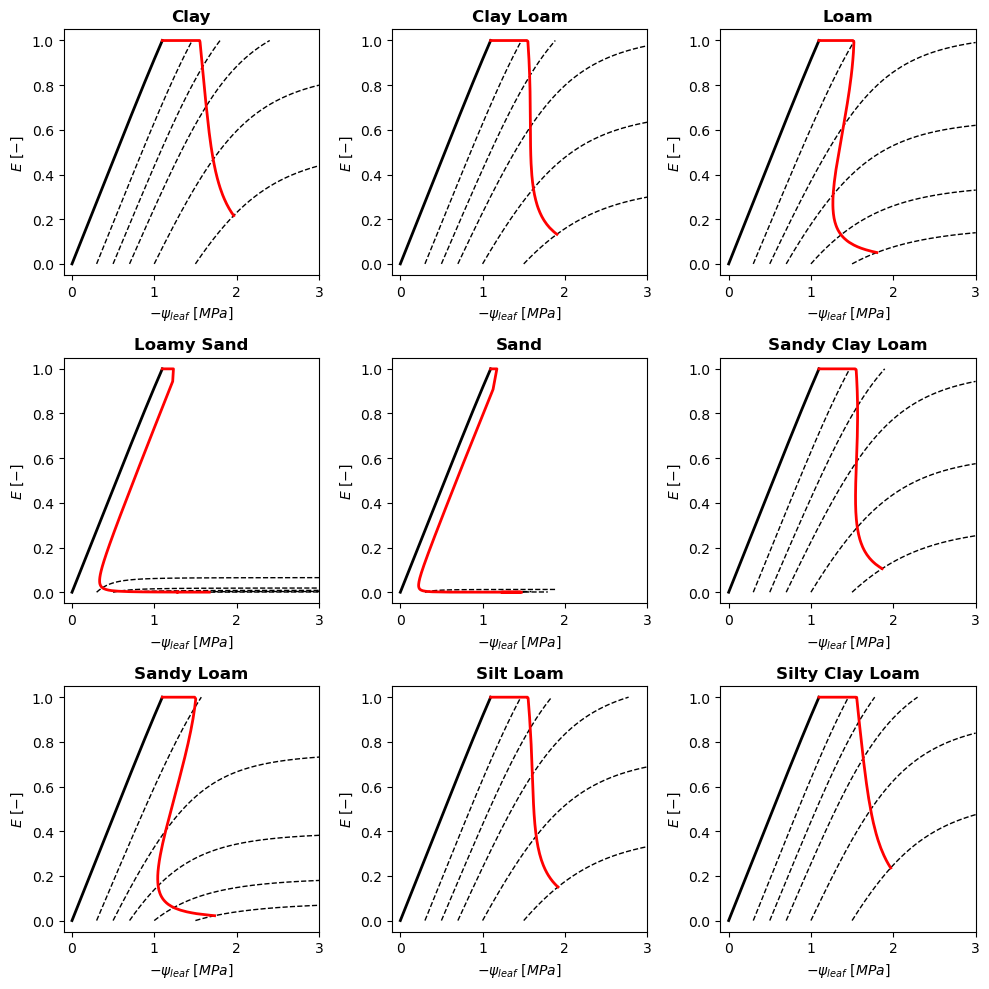

In [28]:
# Plot from the leaf perspective

plt.figure(1)
plt.subplots_adjust(hspace=5)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, soil in enumerate(soil_Data):
    trajectory2 = soil_Data[soil]["traject"]

    trajecthsoil1 = soil_Data[soil]["trajecthsoil_-10"]
    trajecthsoil30 = soil_Data[soil]["trajecthsoil_-3000"]
    trajecthsoil50 = soil_Data[soil]["trajecthsoil_-5000"]
    trajecthsoil70 = soil_Data[soil]["trajecthsoil_-7000"]
    trajecthsoil100 = soil_Data[soil]["trajecthsoil_-10000"]
    trajecthsoil150 = soil_Data[soil]["trajecthsoil_-15000"]

    ax = plt.subplot(3, 3, i + 1)

    ax.set_title(soil, weight='bold') # title with soil name
    ax.plot(-trajecthsoil1 * 1e-4, E / np.nanmax(E), 'k', linewidth=2)
    ax.plot(-trajecthsoil30 * 1e-4, E / np.nanmax(E), 'k--', linewidth=1)
    ax.plot(-trajecthsoil50 * 1e-4, E / np.nanmax(E), 'k--', linewidth=1)
    ax.plot(-trajecthsoil70 * 1e-4, E / np.nanmax(E), 'k--', linewidth=1)
    ax.plot(-trajecthsoil100 * 1e-4, E / np.nanmax(E), 'k--', linewidth=1)
    ax.plot(-trajecthsoil150 * 1e-4, E / np.nanmax(E), 'k--', linewidth=1)
    ax.plot(-trajectory2[:, 1] * 1e-4, trajectory2[:, 2] / np.nanmax(E), 'r', linewidth=2)

    # Labels
    ax.set_xlabel(r'$-\psi_{leaf} \ [MPa]$')
    ax.set_ylabel(r'$E \ [-]$')

    ax.set_xbound(lower=-0.1, upper=3)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

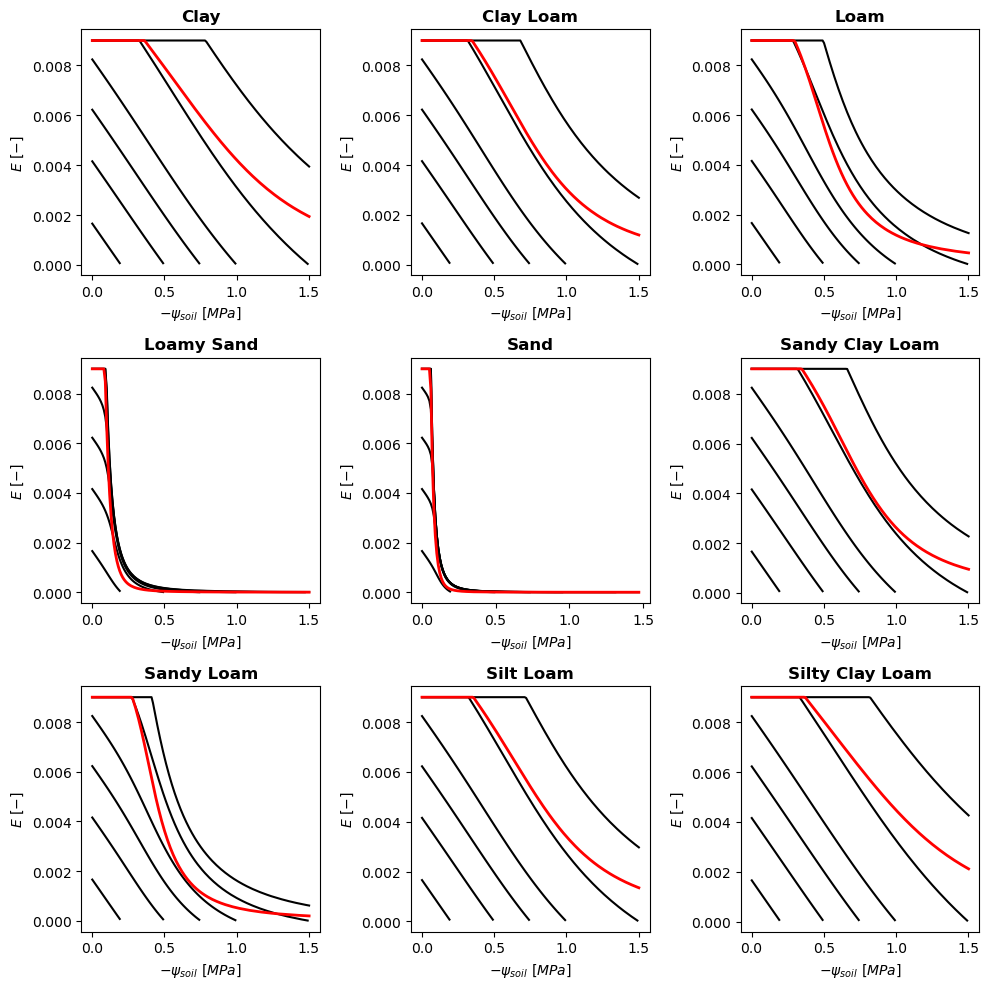

In [22]:
# Plot from the soil perspective

plt.figure(2)
plt.subplots_adjust(hspace=5)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, soil in enumerate(soil_Data):
    trajectory2 = soil_Data[soil]["traject"]

    trajecthleaf2000 = soil_Data[soil]["trajecthleaf_-2000"]
    trajecthleaf5000 = soil_Data[soil]["trajecthleaf_-5000"]
    trajecthleaf7500 = soil_Data[soil]["trajecthleaf_-7500"]
    trajecthleaf10000 = soil_Data[soil]["trajecthleaf_-10000"]
    trajecthleaf15000 = soil_Data[soil]["trajecthleaf_-15000"]
    trajecthleaf30000 = soil_Data[soil]["trajecthleaf_-30000"]

    ax = plt.subplot(3, 3, i + 1)

    ax.set_title(soil, weight='bold') # title with soil name
    ax.plot(-trajecthleaf7500[:,0] * 1e-4, trajecthleaf7500[:,1], 'k')
    ax.plot(-trajecthleaf2000[:,0] * 1e-4, trajecthleaf2000[:,1], 'k')
    ax.plot(-trajecthleaf5000[:,0] * 1e-4, trajecthleaf5000[:,1], 'k')
    ax.plot(-trajecthleaf10000[:,0] * 1e-4, trajecthleaf10000[:,1], 'k')
    ax.plot(-trajecthleaf15000[:,0] * 1e-4, trajecthleaf15000[:,1], 'k')
    ax.plot(-trajecthleaf30000[:,0] * 1e-4, trajecthleaf30000[:,1], 'k')
    ax.plot(-trajectory2[:, 0] * 1e-4, trajectory2[:, 2], 'r', linewidth=2)

    # Labels
    ax.set_xlabel(r'$-\psi_{soil} \ [MPa]$')
    ax.set_ylabel(r'$E \ [-]$')


plt.tight_layout()
plt.show()